In [1]:
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)

In [3]:
DEFAULT_FIGSIZE = (14, 7)

In [4]:
records = lidar.load_records(sync=False)

Unable to determine range 2
Unable to determine range 1


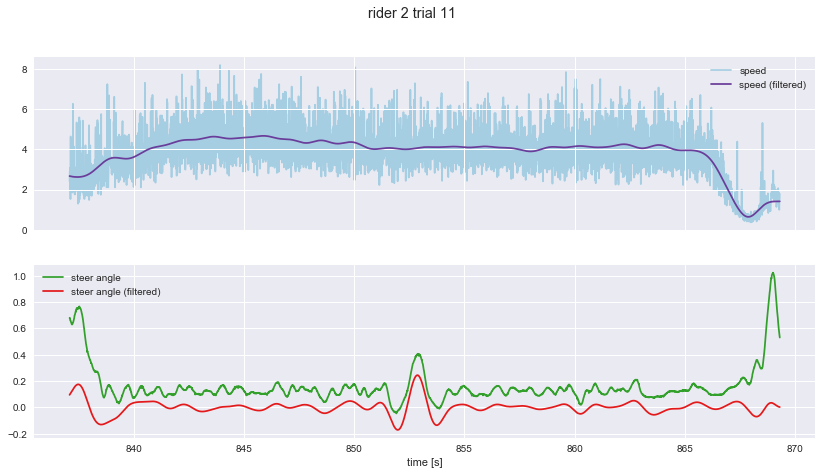

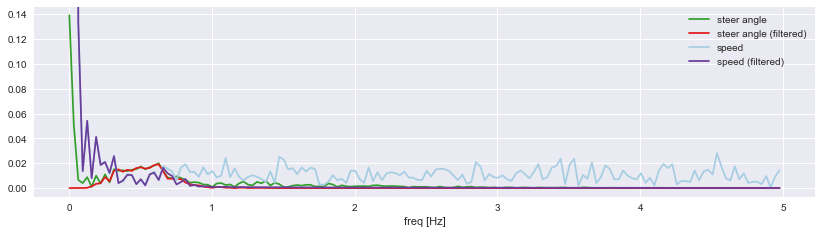

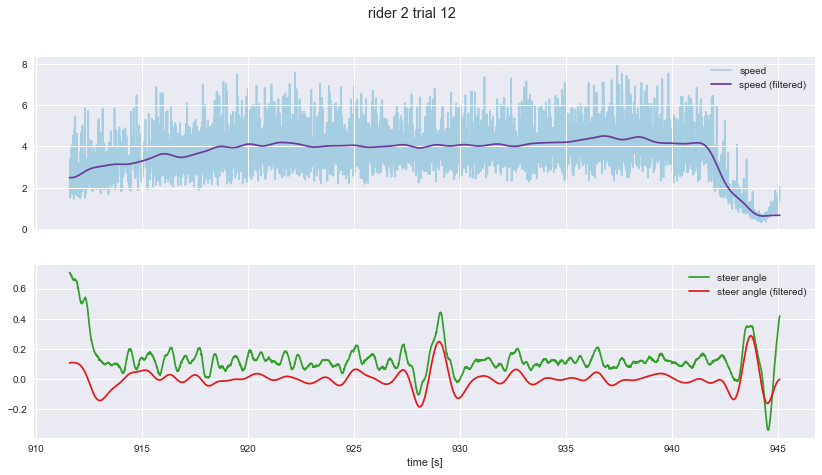

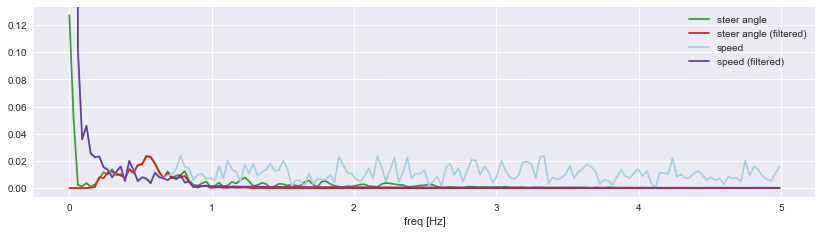

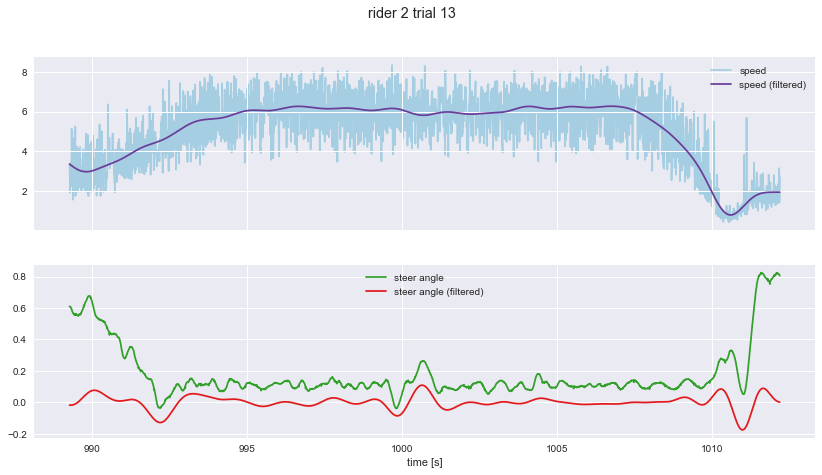

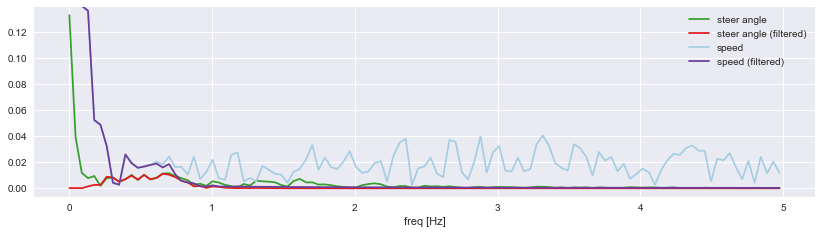

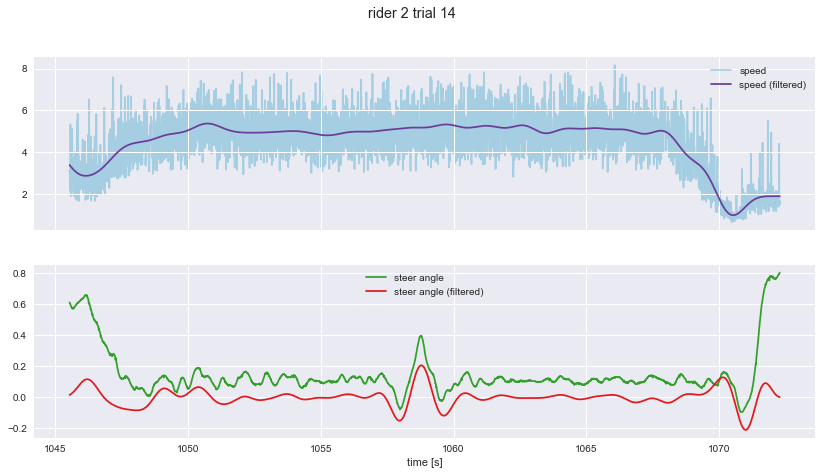

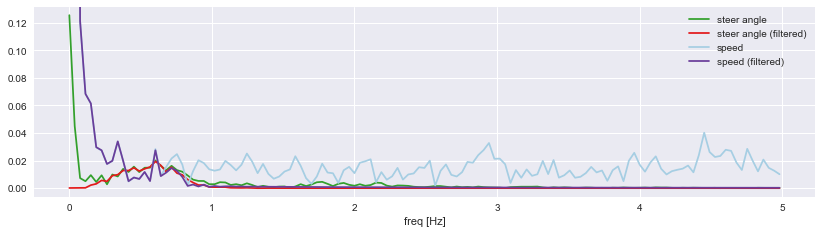

In [5]:
import numpy as np
import seaborn as sns
colors = sns.color_palette('Paired', 12)

from antlia.filter import fft
import scipy.signal

fs = 125 # sample frequency in Hz

# steer angle filter
def f(x):
    order = 3
    fcut = np.array([0.2, 0.9]) # Hz
    wn = fcut / (0.5 * fs)
    b, a = scipy.signal.butter(order, wn, btype='bandpass')
    return scipy.signal.filtfilt(b, a, x)

# maximum frequency to plot
max_freq = 5 # Hz
def g(x):
    freq, xf = fft(x, 1/fs)
    return freq[freq < max_freq], xf[freq < max_freq]

# speed filter
def h(x):
    order = 5
    apass = 0.001 # dB
    fcut = 0.5
    wn = fcut / (0.5*fs)
    b, a = scipy.signal.cheby1(order, apass, wn)
    return scipy.signal.filtfilt(b, a, x)

rid = 2
r = records[rid]
for tid in [11, 12, 13, 14]:
    trial = r.trial(tid)
    v = h(trial.speed)
    y = f(trial['steer angle'])
    
    _, ax = plt.subplots(2, 1, sharex=True, figsize=DEFAULT_FIGSIZE)
    ax[0].plot(trial.time, trial.speed, label='speed',
               color=colors[0], zorder=0)
    ax[0].plot(trial.time, v, label='speed (filtered)',
               color=colors[9], zorder=1)
    
    ax[1].plot(trial.time, trial['steer angle'],
               color=colors[3], label='steer angle')
    ax[1].plot(trial.time, y,
               color=colors[5], label='steer angle (filtered)')
    for axi in ax:
        axi.legend()
    ax[1].set_xlabel('time [s]')
    set_title(ax[0], 'rider {} trial {}'.format(rid, tid))
    
    _, ax = plt.subplots(figsize=(DEFAULT_FIGSIZE[0], DEFAULT_FIGSIZE[1]/2))
    ax.plot(*g(trial['steer angle']), color=colors[3], label='steer angle')
    ylim = ax.get_ylim()
    
    ax.plot(*g(y), color=colors[5], label='steer angle (filtered)')
    ax.plot(*g(trial.speed), color=colors[0], label='speed')
    ax.plot(*g(v), color=colors[9], label='speed (filtered)')
    ax.set_ylim(ylim)
    
    ax.set_xlabel('freq [Hz]')
    ax.legend()
plt.show()